In [17]:
import ticktack
from jax.numpy import array, pi, exp, sin, mean, median, var, arange, sum
from numpy import random
from pandas import DataFrame
from plotnine import ggplot, facet_wrap, labs, aes, theme_bw, geom_tile, scale_color_cmap
from os import getcwd, walk

The basic question is what is the probability of detecting consecutive events based on the distribution of the data. The first step then will be to determine the distribution of the data. This will be done be resampling the points after the event has been removed.

In [18]:
models = { # This dictionary contains the units for the fluxes and production function
    "Guttler14": {  # Units of the Guttler 2014 paper
        "production_rate_units": "atoms/cm^2/s",    # Units of the production rate 
        "flow_rate_units": "Gt/yr"                  # Units of the fluxes
    },
    "Brehm21": {    # Units used by the Brehm, et. al. paper
        "production_rate_units": "kg/yr",    # Units of the production rate
        "flow_rate_units": "Gt/yr"           # Units of the fluxes
    },
    "Buntgen18": {  # The units used by the Buntgen 2018 paper
        "production_rate_units": "atoms/cm^2/s",    # Units of the production function
        "flow_rate_units": "Gt/yr"                  # Units of the fluxes 
    },
    "Miyake17": {   # The units used by the Miyake 2017 et. al. paper
        "production_rate_units": "atoms/cm^2/s",    # Units of the production function 
        "flow_rate_units": "1/yr"                   # Units of the fluxes.
    }
}

In [19]:
data_sets = []  # List for storing the data set locations
data_sets_directory = f"{getcwd()}/datasets" # Home directory of the data 
for (root, dirs, files) in walk(data_sets_directory):    # Looping over directories 
    for file in files:  # Looping through the files 
        file_path = root + "/" + file   # Setting up the path 
        data_sets.append(file_path)  # Extending the stored directoriess

The function below will also have a `shape` parameter eventually. First however I want to get this running. Damn this really is well suited to a class structure since then I can set `self.set_annual_samples()` need to check if this has actually been implemented. The answer is __No__. I need to add the growth seasons to the `model_units` (which I might just rename `models`). This will lead to ?two? extra field `hemisphere_model` (bool) and `growth_seasons`. Alternatively this could result in a further nested dictionary like `hemispheres = {"NH_growth": array([]), "SH_growth": array([])}`

In [20]:
def get_model(model: str, datum: str):
    cbm = ticktack.load_presaved_model( # Generating the CarbobBoxModel using ticktack
        model,  # Name of the model as looped from the models dictionary 
        production_rate_units=models[model]["production_rate_units"], 
        flow_rate_units=models[model]["flow_rate_units"]
    )

    bayesian_model = ticktack.fitting.SingleFitter(cbm)   # Fitting a model 
    bayesian_model.prepare_function(model="simple_sinusoid")# Generating the simple sin model
    bayesian_model.load_data(datum)   # Loading the data into the model  

    return bayesian_model

In [21]:
def get_production_function(model: ticktack.fitting.SingleFitter):
    """
    Parameters:
        model: `str` - The `CarbonBoxModel` that is to be used
        data: `str` - The dataset that the production function is to be fitted to (.csv)
    Returns:
        production: `function` - The ideal production function 
    """
    def mcmc_parameters():
        """
        A Wrapper function to mask the initial position from the function namespace and allow for smoother `try catch`
        """
        initial_parameters = array( # Array of initial parameters
            [model.time_data[len(model.time_data) // 2], # Guessing the event start 
            1./12,  # This is the duration guessing 1 month
            pi/2.,  # This is the phase 
            81./12] # This is the area 
        )

        return model.MarkovChainSampler(    # An array of samples for all of the parameters
            initial_parameters,    # Initial position within the parameters space    
            likelihood=model.log_likelihood,   # likelihood function 
            burnin=200,                             # Truncated burnin for testing 
            production=500,                          # Truncated production for testing 
            k = 4
        )
    
    try:
        samples = mcmc_parameters()
    except ValueError:
        print("Large condition number encountered: \n" +
            "\t Trying again:")

    parameters = {  # A dictionary of the model parameters for the `simple_sinusoid`
        "Start Date (yr)": None,    # The year that the event began 
        "Duration (yr)": None,      # Number of years that the event occured over 
        "Phase (yr)": None,         # The phase shift of the sinusoidal production function 
        "Area": None               #? What are the units?
    } 

    for i, parameter in enumerate(parameters):  # Looping through the parameters 
        parameters[parameter] = {   # Nested dictionary to store statistical information
            "mean": mean(samples[:, i]),    # Storing the mean of the samples produced by mcmc
            "median": median(samples[:, i]),# Storing the median in addition to the mean 
            "variance": var(samples[:, i])  # Storing the variance of the parameter
        }
    parameters["Steady Production"] = model.steady_state_production   
    
    return parameters

In [22]:
def production(t: float, params: dict):
    """
    The best fit production function as estimated using `mcmc`
    """
    middle = params["Start Date (yr)"]["mean"] + \
        params["Duration (yr)"]["mean"] / 2.0    # Calculating the center of the event
    height = params["Area"]["mean"] / params["Duration (yr)"]["mean"] # The magnitude of the event 

    gauss = height * exp(- ((t - middle) / (1. / 1.93516 * \
        params["Duration (yr)"]["mean"])) ** 16.)   # The super-gaussian event

    sine = params["Steady Production"] + \
        0.18 * params["Steady Production"] * \
        sin(2 * pi / 11 * t + params["Phase (yr)"]["mean"]) # Sinusoidal component of production 
    
    return sine + gauss

In [23]:
def get_residual_distribution(model: ticktack.fitting.SingleFitter, params: list):
    """
    Parameters:
        production: function - The production function, typically determined using `get_production_function`.
        data: str - The file name of the data. Should be the same as the file name that was provided to `get_production_function`.
    Returns:
        An `mcmc` sample of the posterior distribution of the residuals, which has been fitted with a parameteric (to start) distribution that can be used to simulate noise.
    """
    residuals = model.d14c_data - model.dc14(params)

    gaussian_error_parameters = {   # Dictionary containing the parameters of a parametric gaussian
        "mean": mean(residuals),    # The mean of the residuals assumed to have gaussian error
        "variance": var(residuals)  # Variance of the residuals assumed to have gaussian error
    }

    return gaussian_error_parameters
    

So the error in the data measurements will have a distribution that I can use to generate imaginary error in the data. I'm not sure how this will help but it could change the way things shape out so I will implement this and keep track of it. 

In [24]:
def simulate_error(model: ticktack.fitting.SingleFitter, error: dict, theoretical_dc14: array):
    """
    Simulates a Miyake event based on the things that have already transpired. 
    """   
    random_error = random.randn(len(model.d14c_data)) * \
        error["residuals"]["variance"] + error["residuals"]["mean"] # Generating the noise 
    
    measurement_error = random.randn(len(model.d14c_data_error)) * \
        error["error"]["variance"] + error["error"]["mean"]

    data = {    # A Dictionary that I will convert to a DataFrame and return 
        "Year": model.time_data,        # The time series data 
        "DC14": theoretical_dc14 + random_error,           # Simulated C14 data
        "Sig_DC14": measurement_error   # Simulated C14 measurement error
    }

    return DataFrame(data)

In [25]:
def recover_event(event: DataFrame, EDC14: array):
    """
    Used to determine how likely an event is to have occured. 
    Parameters:
        event: `DataFrame` -> A simulated event
        EDC14: `array` -> The theoretical values 
    Returns:
        The chi-squared of the simulated event given the EDC14 and the error in the chi-squared
    """
    chi_squared = (array([*event["DC14"]]) - EDC14) ** 2 / EDC14  # Calculates generalised chi squared
    # chi_squared_error = 2 * array([*event["Sig_DC14"]])   # Error propagation of chi-sqaured 
    return float(sum(chi_squared))

In [26]:
test_models = {model: models[model] for model in ["Guttler14", "Miyake17"]} # Extracting two test models
test_data = data_sets[:2]   # Test data sets to run the test models on

In [27]:
simulations = {             # Holds the data farmed from the simulation 
    "Model": [],            # The model that was used in the simulation
    "Data": [],             # Holds the name of the dataset
    "Height": [],           # The peak height of the production function 
    "Duration": [],         # The duration of the productioin function 
    "Chi Squared": [],      # The chi-squared of the model 
    "Chi Squared Error": [] # The error in the chi-squared
}

for model in test_models:   # Looping over the models 
    for datum in test_data: # Looping over the data
        datum_str = datum.split("/")[-1]    # Just storing the csv name not the whole adress path 
        
        print(  
            f"Current Model = {model} \n" +
            f"Current Datum = {datum_str}"
        )

        model_obj = get_model(model, datum)    # Loading the model into RAM
        production_params = get_production_function(model_obj)   # Getting the production function 
        #! Could it be the assignment out of scope? I need to check that I am still using the event parameters that are getting passed.
        model_obj.production = production   # Assigning the production function 
        data_error = get_residual_distribution(model_obj, [production_params])  # Getting error 

        for height in arange(0.1, 8.0):   # Looping over a range of areas 
            for duration in arange(0.1, 8.0):   # Looping over a range of durations
                event_params = production_params.copy()             # Copying the parameters 
                event_params["Area"]["mean"] = height * duration    # Updating the area parameter
                event_params["Duration (yr)"]["mean"] = duration    # Changing the duration 

                theoretical_dc14 = model_obj.dc14([event_params])      # Running the model 
                event = simulate_error(model_obj, data_error, theoretical_dc14)  # Running simulation 
                chi_squared, error = recover_event(event, theoretical_dc14) # getting shi 

                simulations["Data"].append(datum_str)           # Storing the data
                simulations["Model"].append(model)              # Storing the model 
                simulations["Height"].append(height)            # Storing the simulation area
                simulations["Duration"].append(duration)        # Storing the simulations duration 
                simulations["Chi Squared"].append(chi_squared)  # Storing the chi-squared
                simulations["Chi Squared Error"].append(error)  # Storing chi-squared error 

        print("\n") # New line for nicer terminal display 

Current Model = Guttler14 
Current Datum = Miyake21_Finland2.csv
Running burn-in...


 23%|██▎       | 46/200 [00:09<00:28,  5.40it/s]

So it is starting to come together. I need to work out what is causing the huge variance in the chi-squared though. I might do this on some smaller meshes. 
I also might want to plot all the data sets so that I can see what I am dealing with. I'll make this the first goal for after lunch.

/home/jordan/anaconda3/envs/ticktack/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


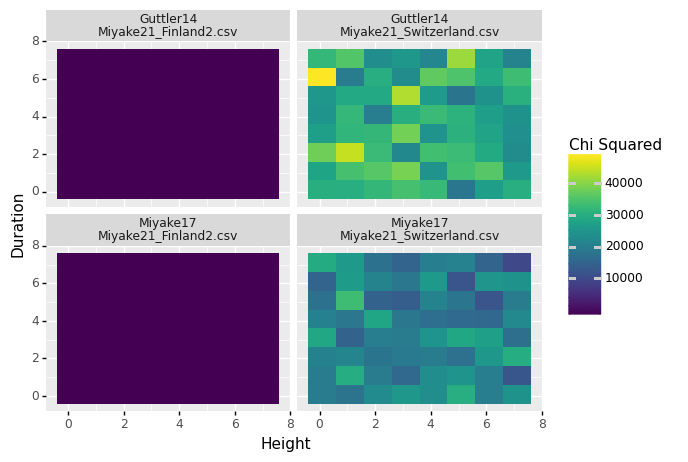

<ggplot: (8735565490963)>

In [ ]:
simulations = DataFrame(simulations)
(ggplot(simulations, aes(x="Height", y="Duration", fill="Chi Squared"))
    + geom_tile()
    + scale_color_cmap(cmap_name="Spectral")
    + facet_wrap("~Model + Data"))

In [ ]:
simulations

,Model,Data,Height,Duration,Chi Squared,Chi Squared Error
0,Guttler14,Miyake21_Finland2.csv,0.1,0.1,75.066859,34.192317
1,Guttler14,Miyake21_Finland2.csv,0.1,1.1,87.233876,34.215857
2,Guttler14,Miyake21_Finland2.csv,0.1,2.1,112.987341,34.221395
3,Guttler14,Miyake21_Finland2.csv,0.1,3.1,104.177450,34.183007
4,Guttler14,Miyake21_Finland2.csv,0.1,4.1,64.338695,34.191387
...,...,...,...,...,...,...
251,Miyake17,Miyake21_Switzerland.csv,7.1,3.1,17302.961172,207.205419
252,Miyake17,Miyake21_Switzerland.csv,7.1,4.1,22523.128907,210.646634
253,Miyake17,Miyake21_Switzerland.csv,7.1,5.1,19614.696007,205.446106
254,Miyake17,Miyake21_Switzerland.csv,7.1,6.1,24422.900990,207.222991


Kernel density information will enable me to get the maximum likelhood as well as the mean and median.